In [19]:
import os
import glob
import cv2
import numpy as np
import time
import torch
import torch.nn as nn
from utils import *
import onnx.numpy_helper as nph
from matplotlib import pyplot as plt

from model import Detect
from finn.util.visualization import showSrc, showInNetron

In [5]:
showInNetron(model_path)

Stopping http://0.0.0.0:8078
Serving '/home/omar/finn/notebooks/lpyoloW4A4_nodetect_quant.onnx' at http://0.0.0.0:8078


In [2]:
nc = 7
anchors = np.array([[10, 13, 16, 30, 33, 23], [81, 82, 135, 169, 344, 319], [116, 90, 156, 198, 373, 326]])
detect_head = Detect(nc, anchors,ch=[36,36,36],do_quant=False)
detect_head.load_state_dict(torch.load(os.environ['FINN_ROOT'] + "/notebooks/build_model/detect_module.pt",map_location=torch.device('cpu')))
detect_head.eval()

Detect(
  (m): ModuleList(
    (0): Conv2d(36, 36, kernel_size=(1, 1), stride=(1, 1))
    (1): Conv2d(36, 36, kernel_size=(1, 1), stride=(1, 1))
    (2): Conv2d(36, 36, kernel_size=(1, 1), stride=(1, 1))
  )
)

In [16]:
import finn.core.onnx_exec as oxe
from qonnx.core.modelwrapper import ModelWrapper
from qonnx.util.cleanup import cleanup
from qonnx.core.datatype import DataType
import cv2

img_path =  os.environ['FINN_ROOT'] + "/notebooks/bus.jpg"

image = cv2.imread(img_path)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

image_org = image.copy()

image = letterbox(image, (384,640), auto=False)[0]
input_batch = np.expand_dims(image, 0)
image = image.astype(np.uint8)
np.save("input.npy",input_batch)
input_batch = np.transpose(input_batch, (0,3,1,2))
input_batch = input_batch.astype(np.float32)


model_name = "lpyoloW4A4"
model_path = "/home/omar/finn/notebooks/{}_quant.onnx".format(model_name)
model_path_clean = "/home/omar/finn/notebooks/{}_quant_clean.onnx".format(model_name)
cleanup(model_path, out_file=model_path_clean)

model = ModelWrapper(model_path_clean)
input_dict = {"global_in": input_batch}
output_dict = oxe.execute_onnx(model, input_dict)
output_model = output_dict["global_out"]
output_model = torch.from_numpy(output_model)

head_out = detect_head([output_model,output_model,output_model])[0]
head_out = head_out.detach().numpy()
head_out = np.reshape(head_out,(1, 2160, 12))
head_out = torch.from_numpy(head_out)
non_max_suppression(head_out,conf_thres = 0.20, iou_thres=0.35)

[tensor([[187.2256, 142.0748, 246.9758, 303.0508,   0.7307,   0.0000],
         [248.0219, 126.9167, 299.8268, 306.9815,   0.6356,   0.0000],
         [222.1539,  78.9942, 455.7329, 290.6852,   0.5677,   4.0000],
         [421.2170, 180.7584, 462.0644, 302.9682,   0.4844,   0.0000]])]

In [20]:
scale = np.load("scale.npy")
accel_out = np.load("output.npy")

accel_out = accel_out.transpose(0,3,1,2)
accel_out = accel_out*scale

accel_out = torch.from_numpy(accel_out)

head_out = detect_head([accel_out,accel_out,accel_out])[0]
head_out = head_out.detach().numpy()
head_out = np.reshape(head_out,(1, 2160, 12))
head_out = torch.from_numpy(head_out)

pred = non_max_suppression(head_out,conf_thres = 0.20, iou_thres=0.35)
print(pred)

[tensor([[187.2256, 142.0748, 246.9758, 303.0508,   0.7307,   0.0000],
        [248.0219, 126.9167, 299.8268, 306.9815,   0.6356,   0.0000],
        [222.1539,  78.9942, 455.7328, 290.6852,   0.5677,   4.0000],
        [421.2170, 180.7584, 462.0644, 302.9682,   0.4844,   0.0000]])]


[tensor([[187.2256, 142.0748, 246.9758, 303.0508,   0.7307,   0.0000],
        [248.0219, 126.9167, 299.8268, 306.9815,   0.6356,   0.0000],
        [222.1539,  78.9942, 455.7328, 290.6852,   0.5677,   4.0000],
        [421.2170, 180.7584, 462.0644, 302.9682,   0.4844,   0.0000]])]
3 person
1 bus


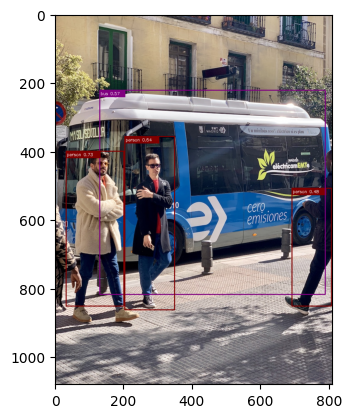

In [21]:
names = [
    "person",
    "bicycle",
    "car",
    "motorcycle",
    "bus",
    "train",
    "truck"
]


boxes_detected, class_names_detected, probs_detected = [], [], []
print(pred)
# Process predictions
for i, det in enumerate(pred):  # per image
    if len(det):
        # Rescale boxes from img_size to im0 size
        det[:, :4] = scale_coords(image.shape, det[:, :4], image_org.shape).round()
        # Print results
        for c in np.unique(det[:, -1]):
            n = (det[:, -1] == c).sum()  # detections per class
            print(f"{n} {names[int(c)]}")  # add to string
        # Write results
        for *xyxy, conf, cls in reversed(det):
            c = int(cls)  # integer class
            label = f'{names[c]} {conf:.2f}'
            boxes_detected.append(xyxy)
            class_names_detected.append(names[c])
            probs_detected.append(conf)


image_boxes = visualize_boxes(image_org, boxes_detected, class_names_detected, probs_detected)
cv2.imwrite("output.jpg", cv2.cvtColor(image_boxes, cv2.COLOR_BGR2RGB))

plt.imshow(image_boxes)
plt.show()